## Предобработка данных


In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import ttest_ind
import pingouin as pg
import seaborn as sns


from tqdm.auto import tqdm

plt.style.use('ggplot')

In [2]:
df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-m-fahretdinov/Statictics/hw_bootstrap.csv', sep=';', decimal=',')

In [3]:
df.head()

,Unnamed: 0,value,experimentVariant
0,1,10.380495,Control
1,2,9.546867,Control
2,3,11.088215,Control
3,4,10.147274,Control
4,5,9.789808,Control


/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [8]:
df.query("experimentVariant == 'Treatment'") 
# в value тестовой группы мы видим аномально большие показатели по сравнению с другими данными-
# в treatment есть 5 значений (с 995 по 999), которые являются аномально большими- на графиках также они
# "съедают" все остальные показатели-поэтому уберем их

,Unnamed: 0,value,experimentVariant
500,501,10.380495,Treatment
501,502,9.546867,Treatment
502,503,11.088215,Treatment
503,504,10.147274,Treatment
504,505,9.789808,Treatment
...,...,...,...
995,996,1000.000000,Treatment
996,997,1200.000000,Treatment
997,998,1500.000000,Treatment
998,999,2000.000000,Treatment


In [9]:
# В контрольной группе аномалий не наблюдается:
df.query("experimentVariant == 'Control' and value > 15") 

,Unnamed: 0,value,experimentVariant


In [10]:
# перезапишем датасет без учета аномалий:
df = df.query("experimentVariant == ['Treatment', 'Control'] and value < 1000") 

In [11]:
df

,Unnamed: 0,value,experimentVariant
0,1,10.380495,Control
1,2,9.546867,Control
2,3,11.088215,Control
3,4,10.147274,Control
4,5,9.789808,Control
...,...,...,...
990,991,10.916229,Treatment
991,992,11.160869,Treatment
992,993,8.202518,Treatment
993,994,9.782199,Treatment


In [12]:
df.groupby('experimentVariant') \
    .agg({'value': 'mean'}) # вычисляем средние в двух группах

,value
experimentVariant,
Control,10.026867
Treatment,10.021716


In [13]:
df.groupby('experimentVariant') \
    .agg({'value': 'median'}) #медианы

,value
experimentVariant,
Control,10.018465
Treatment,10.015492


In [14]:
# как видим, среднее в котрольной и тестовой группах почти одинаковы

In [15]:
df_control = df.query("experimentVariant == 'Control'")
df_treatment = df.query("experimentVariant == 'Treatment' and value < 1000") #разбиваем контроль и тест на два дф для удобства

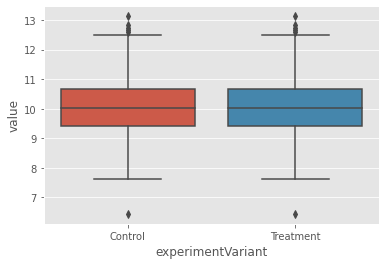

In [17]:
# боксплот для выявления выбросов:
sns.boxplot(data=df, x="experimentVariant", y="value")
# разброс (точки за усиками) у обоих выборок небольшой и, примерно, одинаковый

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


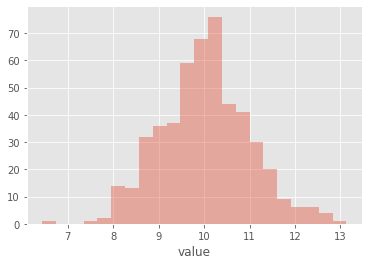

In [18]:
sns.distplot(df[df.experimentVariant == 'Control'].value, kde=False) #смотрим распределение контроля

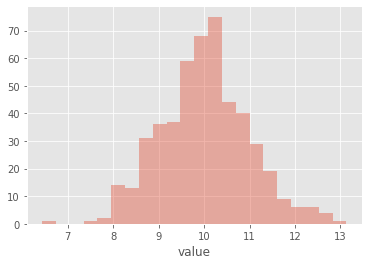

In [19]:
sns.distplot(df[df.experimentVariant == 'Treatment'].value, kde=False) #смотрим распределение теста

# T-test

In [22]:
stats.ttest_ind(df_control.value, df_treatment.value)
# это значит, что мы принимаем нулевую гипотезу о том, что различий между группами нет
# применяется t-test тогда, когда нормальное распределение средних. Мы можем проверить исходный датафрейм
# на нормальность с пом. pg.normalitу, чтобы убедиться в целесообразности исп-ия t-test'а:

Ttest_indResult(statistic=0.0829913510759266, pvalue=0.9338751428058369)

In [24]:
pg.normality(data=df, dv="value", group="experimentVariant", method="normaltest")
# как видим, обе группы распределены ненормально благодаря фильтрации от выбросов

,W,pval,normal
Control,2.943459,0.229528,True
Treatment,3.426451,0.180283,True


# U-тест Манна-Уитни

In [33]:
mannwhitneyu(df[df.experimentVariant == 'Treatment'].value, 
             df[df.experimentVariant == 'Control'].value)

MannwhitneyuResult(statistic=123310.5, pvalue=0.9228386264147465)

In [34]:
# или

In [35]:
len(df_control.value)

500

In [36]:
from scipy.stats import mannwhitneyu

In [37]:
U1, p = mannwhitneyu(df_control.value, df_treatment.value)
print(U1)

124189.5


In [38]:
nx, ny = len(df_control.value), len(df_treatment.value)
U2 = nx*ny - U1
print(U2)

123310.5


In [39]:
print(p)

0.9228386264147465


In [40]:
# U-тест Манна-Уитни используется тогда, если распределение признака отличается
# от нормального. Этот критерий менее чувствителен к экстремальным отклонениям от нормальности и наличию выбросов.
# Т.к. p-value =0.92- Таким образом, мы принимаем 0-вую гипотезу о том, что распределение х (контрольная группа)
# совпадает с тестовой.

# Bootstrap

In [42]:
df_controlling = df.query("experimentVariant == 'Control'").value
df_test = df.query("experimentVariant == 'Treatment'").value

In [43]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа

In [44]:
def get_bootstrap(
    df_controlling, # числовые значения первой выборки
    df_test, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = df_controlling.sample(
            len(df_controlling), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = df_test.sample(
            len(df_controlling), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

In [45]:
# будем пробовать бутстрап на эксп. распределении
np.random.seed(5)

In [46]:
n = 1000

sample_1 = np.random.exponential(scale=1/0.001, size=n)
sample_2 = np.random.exponential(scale=1/0.001, size=n)

df = pd.DataFrame({
    "sample_1": sample_1,
    "sample_2": sample_2
})

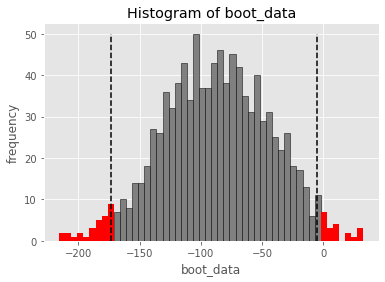

In [47]:
booted_data = get_bootstrap(df.sample_1, df.sample_2) # в результате хранится разница двух распределений, ДИ и pvalue

In [48]:
booted_data["p_value"] # альфа

0.04564731158962379

In [49]:
booted_data["quants"] # ДИ

,0
0.025,-173.270058
0.975,-4.865217


In [50]:
# Бутстрап хорош тем, что он создает модель генеральной совокупности, формируя много маленьких подвыборок
#(с повторениями), тем самым формируя примерную ГС. 

In [52]:
# p-value в гипотезе бутстрапа равно прим. 0,05- мы отклоняем гипотезу о том, что наши выборки не имеют
# стат. значимых различий

In [54]:
# ВЫВОД. Проверяя гипотезы тремя разными способами, я бы остановился на Манна-Уитни; бутстрап я бы не взял в силу того,
# что нам неизвестно, насколько выборки репрезентативна, насколько данные выборки отражают ГС
# что категорически необходимо знать для применения Bootstrap.